In [ ]:
import numpy as np  
import pandas as pd  
import os  
import cv2  
import matplotlib.pyplot as plt  
import seaborn as sns  

import tensorflow as tf  
from tensorflow import keras  
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.utils import to_categorical  
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  
from tensorflow.keras.optimizers import Adam  
from sklearn.model_selection import train_test_split 


In [ ]:
# Define dataset path
dataset_path = "C:\Users\kotia\OneDrive\Desktop\PROJECTS\DATASETS\archive\dataset5\B"

# Get class labels (folders)
labels = sorted(os.listdir(dataset_path))
print("Class Labels:", labels)

# Prepare dataset
data = []
target = []

img_size = 64  # Resize all images to 64x64  

# Load images from each class
for label in labels:
    label_path = os.path.join(dataset_path, label)
    class_index = labels.index(label)  # Convert label to numeric  

    for img in os.listdir(label_path):
        img_path = os.path.join(label_path, img)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
        image = cv2.resize(image, (img_size, img_size))  # Resize image

        data.append(image)
        target.append(class_index)

# Convert lists to NumPy arrays
data = np.array(data).reshape(-1, img_size, img_size, 1)  # Add channel dimension
data = data / 255.0  # Normalize pixel values  
target = to_categorical(np.array(target))  # One-hot encode labels

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42, stratify=target)


Class Labels: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


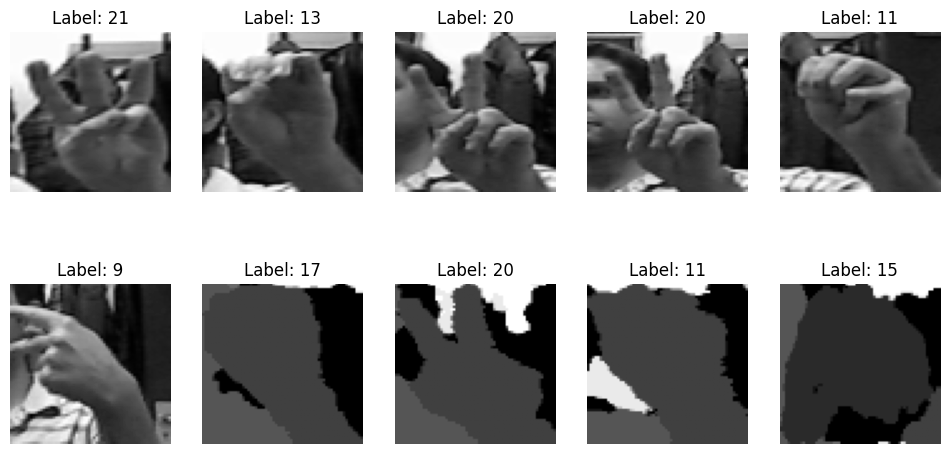

In [7]:
plt.figure(figsize=(12,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train[i].reshape(img_size, img_size), cmap='gray')
    plt.title(f"Label: {np.argmax(y_train[i])}")
    plt.axis("off")
plt.show()


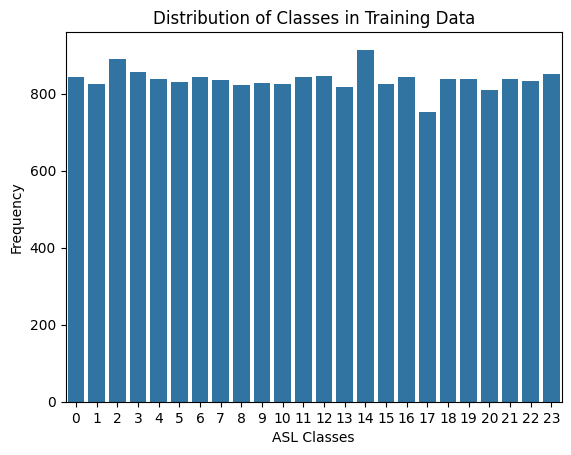

In [8]:
sns.countplot(x=[np.argmax(i) for i in y_train])
plt.xlabel("ASL Classes")
plt.ylabel("Frequency")
plt.title("Distribution of Classes in Training Data")
plt.show()


In [9]:
train_datagen = ImageDataGenerator(  
    rotation_range=10,  
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    zoom_range=0.1,  
    horizontal_flip=False  
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)


In [10]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(len(labels), activation='softmax')  # Output layer with softmax for classification
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)         0

In [11]:
history = model.fit(train_generator, epochs=5, validation_data=(X_test, y_test))


Epoch 1/5
628/628 [==============================] - 175s 274ms/step - loss: 2.1611 - accuracy: 0.3471 - val_loss: 0.7410 - val_accuracy: 0.8023
Epoch 2/5
628/628 [==============================] - 155s 247ms/step - loss: 1.1051 - accuracy: 0.6581 - val_loss: 0.4152 - val_accuracy: 0.8828
Epoch 3/5
628/628 [==============================] - 208s 332ms/step - loss: 0.7953 - accuracy: 0.7499 - val_loss: 0.2622 - val_accuracy: 0.9198
Epoch 4/5
628/628 [==============================] - 3781s 6s/step - loss: 0.6472 - accuracy: 0.7918 - val_loss: 0.1945 - val_accuracy: 0.9445
Epoch 5/5
628/628 [==============================] - 1987s 3s/step - loss: 0.5364 - accuracy: 0.8262 - val_loss: 0.1521 - val_accuracy: 0.9556


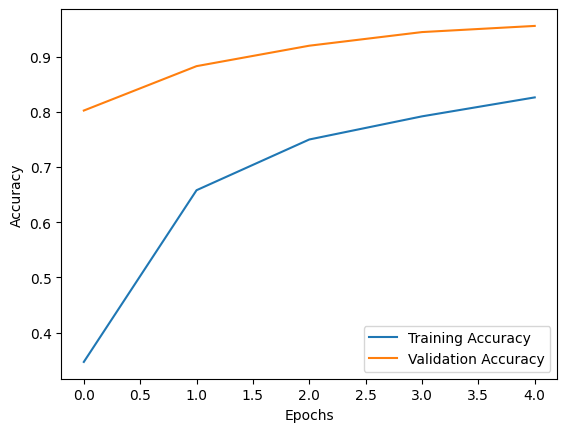

In [12]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


157/157 [==============================] - 12s 74ms/step


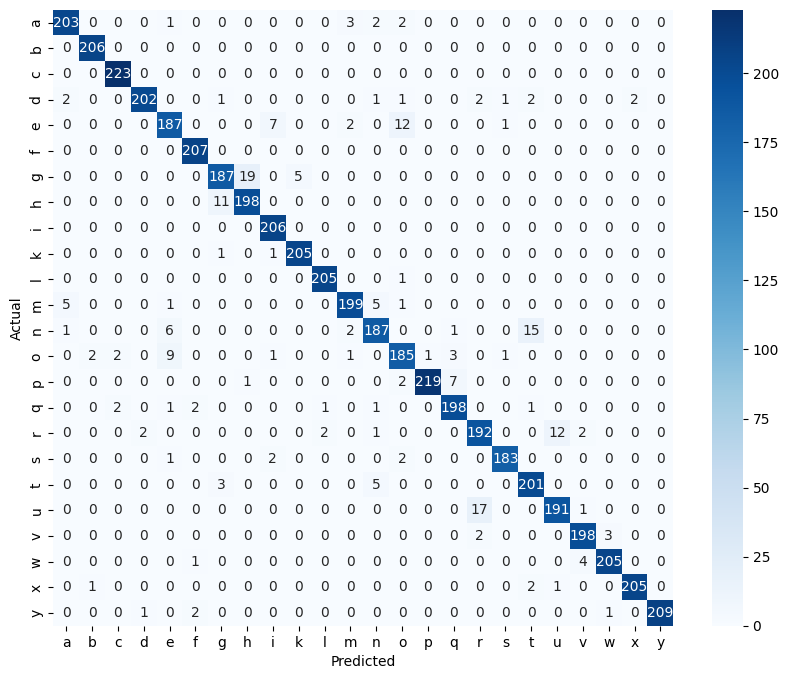

In [13]:
from sklearn.metrics import classification_report, confusion_matrix  

y_pred = model.predict(X_test)  
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true = np.argmax(y_test, axis=1)  

# Confusion matrix  
cm = confusion_matrix(y_true, y_pred_classes)  
plt.figure(figsize=(10,8))  
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)  
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [18]:
# Convert one-hot encoded labels to class indices
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Convert predicted probabilities to class labels
y_train_pred = np.argmax(model.predict(X_train), axis=1)
y_test_pred = np.argmax(model.predict(X_test), axis=1)


157/157 [==============================] - 3s 17ms/step


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [37]:
# Training Set Metrics
train_accuracy = accuracy_score(y_train_labels, y_train_pred)
train_precision = precision_score(y_train_labels, y_train_pred, average='weighted')
train_recall = recall_score(y_train_labels, y_train_pred, average='weighted')
train_f1 = f1_score(y_train_labels, y_train_pred, average='weighted')

print("Training Set Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")

Training Set Metrics:
Accuracy: 0.9576
Precision: 0.9579
Recall: 0.9576
F1 Score: 0.9575


In [38]:
# Testing Set Metrics
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
test_precision = precision_score(y_test_labels, y_test_pred, average='weighted')
test_recall = recall_score(y_test_labels, y_test_pred, average='weighted')
test_f1 = f1_score(y_test_labels, y_test_pred, average='weighted')

print("\nTesting Set Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")


Testing Set Metrics:
Accuracy: 0.9556
Precision: 0.9558
Recall: 0.9556
F1 Score: 0.9555


In [39]:
print("\nClassification Report for Training Set:")
print(classification_report(y_train_labels, y_train_pred, target_names=labels))



Classification Report for Training Set:
              precision    recall  f1-score   support

           a       0.98      0.96      0.97       844
           b       0.98      1.00      0.99       825
           c       0.98      1.00      0.99       890
           d       0.99      0.95      0.97       857
           e       0.91      0.89      0.90       838
           f       0.98      1.00      0.99       830
           g       0.95      0.89      0.92       844
           h       0.90      0.97      0.93       836
           i       0.94      1.00      0.97       823
           k       0.97      0.98      0.97       828
           l       0.97      0.99      0.98       825
           m       0.95      0.96      0.96       842
           n       0.94      0.91      0.93       847
           o       0.90      0.88      0.89       818
           p       1.00      0.97      0.98       914
           q       0.97      0.98      0.98       825
           r       0.93      0.89      0

In [40]:
print("\nClassification Report for Testing Set:")
print(classification_report(y_test_labels, y_test_pred, target_names=labels))


Classification Report for Testing Set:
              precision    recall  f1-score   support

           a       0.96      0.96      0.96       211
           b       0.99      1.00      0.99       206
           c       0.98      1.00      0.99       223
           d       0.99      0.94      0.96       214
           e       0.91      0.89      0.90       209
           f       0.98      1.00      0.99       207
           g       0.92      0.89      0.90       211
           h       0.91      0.95      0.93       209
           i       0.95      1.00      0.97       206
           k       0.98      0.99      0.98       207
           l       0.99      1.00      0.99       206
           m       0.96      0.94      0.95       211
           n       0.93      0.88      0.90       212
           o       0.90      0.90      0.90       205
           p       1.00      0.96      0.98       229
           q       0.95      0.96      0.95       206
           r       0.90      0.91      0.

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrices
train_cm = confusion_matrix(y_train_labels, y_train_pred)
test_cm = confusion_matrix(y_test_labels, y_test_pred)

# Plot function
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()


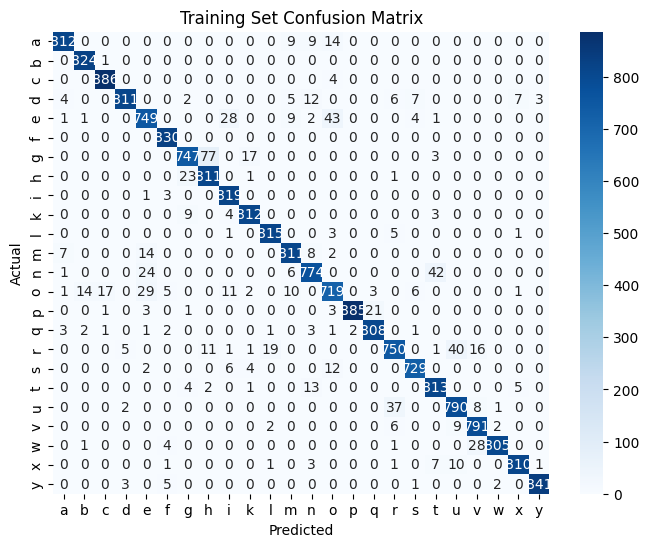

In [29]:
# Plot Confusion Matrices
plot_confusion_matrix(train_cm, "Training Set Confusion Matrix")

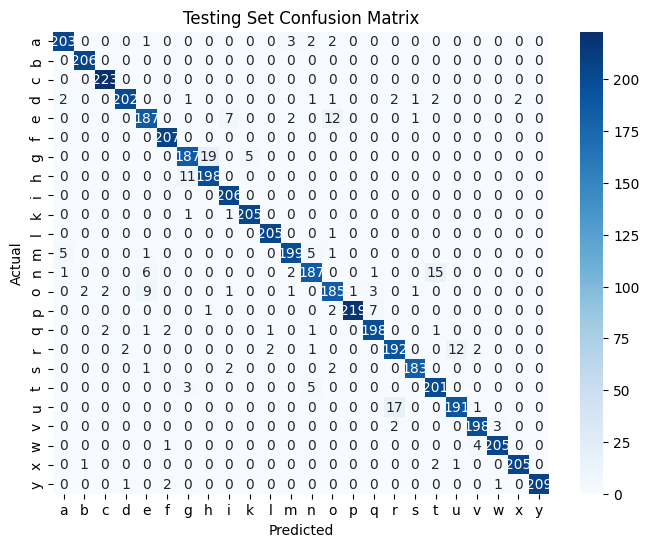

In [30]:
plot_confusion_matrix(test_cm, "Testing Set Confusion Matrix")

In [31]:
# Evaluate model performance
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Testing Accuracy: {test_acc*100:.2f}%")

157/157 [==============================] - 3s 17ms/step - loss: 0.1521 - accuracy: 0.9556
Training Accuracy: 95.76%
Testing Accuracy: 95.56%


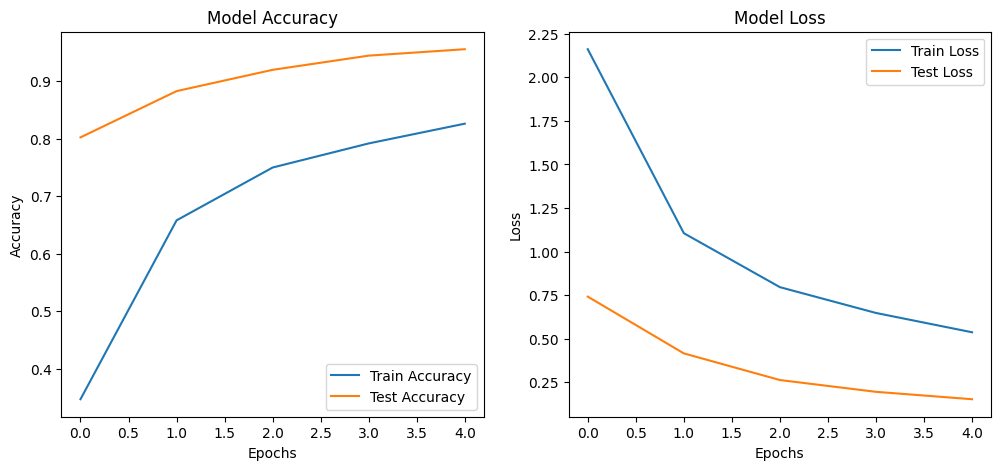

In [32]:
# Plot training accuracy and loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [33]:
# Make predictions
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = np.argmax(y_test, axis=1)

157/157 [==============================] - 2s 14ms/step


In [35]:
# Classification Report
print("Classification Report:\n")
print(classification_report(actual_labels, predicted_labels, target_names=labels))

Classification Report:

              precision    recall  f1-score   support

           a       0.96      0.96      0.96       211
           b       0.99      1.00      0.99       206
           c       0.98      1.00      0.99       223
           d       0.99      0.94      0.96       214
           e       0.91      0.89      0.90       209
           f       0.98      1.00      0.99       207
           g       0.92      0.89      0.90       211
           h       0.91      0.95      0.93       209
           i       0.95      1.00      0.97       206
           k       0.98      0.99      0.98       207
           l       0.99      1.00      0.99       206
           m       0.96      0.94      0.95       211
           n       0.93      0.88      0.90       212
           o       0.90      0.90      0.90       205
           p       1.00      0.96      0.98       229
           q       0.95      0.96      0.95       206
           r       0.90      0.91      0.91       211
   

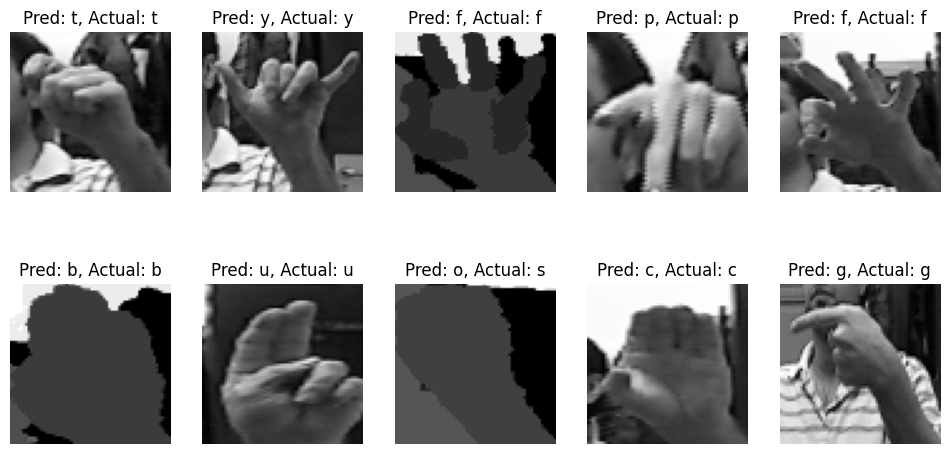

In [36]:
# Display sample predictions
plt.figure(figsize=(12,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[i].reshape(img_size, img_size), cmap='gray')
    plt.title(f"Pred: {labels[predicted_labels[i]]}, Actual: {labels[actual_labels[i]]}")
    plt.axis("off")
plt.show()